# Multi-label Amazon From Space

In [1]:
#@title

! pip -qq install tensorflow-addons
! pip install -qq -U tensorflow_datasets

! wget -q https://raw.githubusercontent.com/DeepVoltaire/AutoAugment/master/autoaugment.py .


IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

import tensorflow as tf

for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [2]:
if IS_COLAB:
  base_dir = '/content/drive/MyDrive'
  data_dir = '/root/tensorflow_datasets'
else:
  base_dir = '/home/ldavid/Workspace'
  data_dir = '/home/ldavid/Workspace/datasets'

import tensorflow_addons as tfa
from autoaugment import ImageNetPolicy


class Config:
  class data:
    path = f'{data_dir}/amazon-from-space'
    size = (256, 256)
    shape = (*size, 3)
    batch_size = 32
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 2142
    shuffle = False

    valid_size = 0.3

    preprocess = tf.keras.applications.efficientnet.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

    aug_policy = ImageNetPolicy()
    
  class model:
    pool_layer = 'avg_pool'
    backbone = tf.keras.applications.EfficientNetB3

    feature_layers = ['block5a_expand_activation', 'block6a_expand_activation', 'top_activation']

    build_options = {
      'predictions': {
        'kernel_regularizer': tf.keras.regularizers.L2(0.01),
        # 'bias_regularizer': tf.keras.regularizers.L2(0.01),
        # 'activity_regularizer': tf.keras.regularizers.L2(0.01),
      }
    }
  
  class training:
    epochs = 80
    learning_rate = .1

    loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True, reduction=tf.keras.losses.Reduction.AUTO)
    optimizer = tf.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=0.9,
      nesterov=True
    )

    logs    = f'{base_dir}/logs/amazon-from-space-mo444/eb6-ce-full/'
    weights = f'{base_dir}/models/amazon-from-space-mo444/eb6-ce-full.h5'

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
      tf.keras.callbacks.TensorBoard(logs, profile_batch=0),
      tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.001, verbose=1),
      tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.01, verbose=1),
    ]

  class fine_tuning:
    epochs = 80
    learning_rate = .01

    loss = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True, reduction=tf.keras.losses.Reduction.AUTO)
    optimizer = tf.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=0.9,
      nesterov=True
    )

    # lr_schedule = tf.optimizers.schedules.ExponentialDecay(1e-4, 100, 0.9)
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)
    # optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=lambda : None)
    # optimizer.weight_decay = lambda : wd_schedule(opt.iterations)

    logs    = f'{base_dir}/logs/amazon-from-space-mo444/eb6-ce-full-ft/'
    weights = f'{base_dir}/models/amazon-from-space-mo444/eb6-ce-full-ft.h5'

    callbacks = [
      tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
      tf.keras.callbacks.TensorBoard(logs, profile_batch=0, histogram_freq=1),
      tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001, verbose=1),
      tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.01, verbose=1),
    ]

    unfreeze_layers = 1.0  # 60%
    frozen_bn = False

  class experiment:
    seed = 41248
    override = True

## Setup

In [3]:
import os
import shutil
from math import ceil

from typing import List, Optional

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [4]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [5]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set()

In [6]:
def opt_or_default(options):
  def _get_options(param):
    return options.get(param, {})
  
  return _get_options


def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [7]:
tf.keras.Model

tensorflow.python.keras.engine.training.Model

In [8]:
def unfreeze_top_layers(
    model: tf.keras.Model,
    layers: float,
    freeze_bn: bool
):
  if not layers:
    model.trainable = False
    return

  model.trainable = True

  frozen_layer_ix = int((1-layers) * len(model.layers))
  for ix, l in enumerate(model.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not freeze_bn))
  
  print(f'Unfreezing {layers:.0%} layers. Bottom-most is the {frozen_layer_ix}-nth layer ({model.layers[frozen_layer_ix].name}).')

## Dataset

### Fetching from Drive

In [9]:
%%time
%%bash

if [ ! -d /root/tensorflow_datasets/amazon-from-space/ ]; then
  mkdir -p /root/tensorflow_datasets/amazon-from-space/

  gdown --id 11DFKx6xQ2-I_zgZtvxUrCjq-50odGP5N --output /root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords
  # If the above is not working:
  # cp /content/drive/MyDrive/datasets/amazon-from-space/train-jpg.tfrecords \
  #    /root/tensorflow_datasets/amazon-from-space/
else
  echo "Dir $data_path found. Skipping."
fi

Dir  found. Skipping.
CPU times: user 4.35 ms, sys: 15.2 ms, total: 19.6 ms
Wall time: 36.5 ms


In [10]:
class AmazonFromSpace:
    num_train_samples = 40479
    num_test_samples  = 61191

    classes_ = np.asarray(
        ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
         'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze',
         'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'])

    @classmethod
    def int2str(cls, indices):
        return cls.classes_[indices]
    
    @staticmethod
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))

    @staticmethod
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    @staticmethod
    def decode_fn(record_bytes):
        r = tf.io.parse_single_example(record_bytes, {
          'filename': tf.io.FixedLenFeature([], tf.string),
          'image': tf.io.FixedLenFeature([], tf.string),
          'height': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'width': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'channels': tf.io.FixedLenFeature([], tf.int64, default_value=[3]),
          'label': tf.io.VarLenFeature(tf.int64),
        })
        
        r['image'] = tf.reshape(tf.io.decode_raw(r['image'], tf.uint8),
                                (r['height'], r['width'], r['channels']))
        r['label'] = tf.sparse.to_dense(r['label'])

        return r
    
    @classmethod
    def load(cls, tfrecords_path):
        return tf.data.TFRecordDataset(tfrecords_path).map(cls.decode_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
CLASSES = AmazonFromSpace.classes_
CLASSES_INDICES = tf.range(len(CLASSES), dtype=tf.int64)
int2str = AmazonFromSpace.int2str
num_samples = AmazonFromSpace.num_train_samples
num_train_samples = int((1-Config.data.valid_size)*num_samples)
num_valid_samples = int(Config.data.valid_size*num_samples)

In [12]:
train_dataset = AmazonFromSpace.load(f'{data_dir}/amazon-from-space/train-jpg.tfrecords')
valid_dataset = train_dataset.take(num_valid_samples)
train_dataset = train_dataset.skip(num_valid_samples)

### Statistics

In [13]:
def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)

In [14]:
l = (
  train_dataset
  .map(lambda item: labels_to_one_hot(item['label']))
  .batch(4 * Config.data.batch_size)
  .prefetch(Config.data.prefetch_buffer_size)
  .reduce(
    initial_state=np.zeros((0, len(CLASSES)), dtype='float32'),
    reduce_func=lambda t, a: tf.concat((t, a), axis=0)
  )
  .numpy()
)

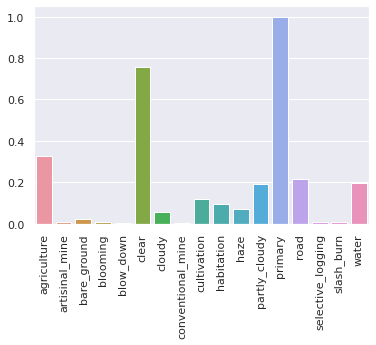

In [15]:
counts = l.sum(axis=0)

sns.barplot(x=CLASSES, y=counts / counts.max())
plt.xticks(rotation=90);

In [16]:
co_occurrence = tf.transpose(l) @ l
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

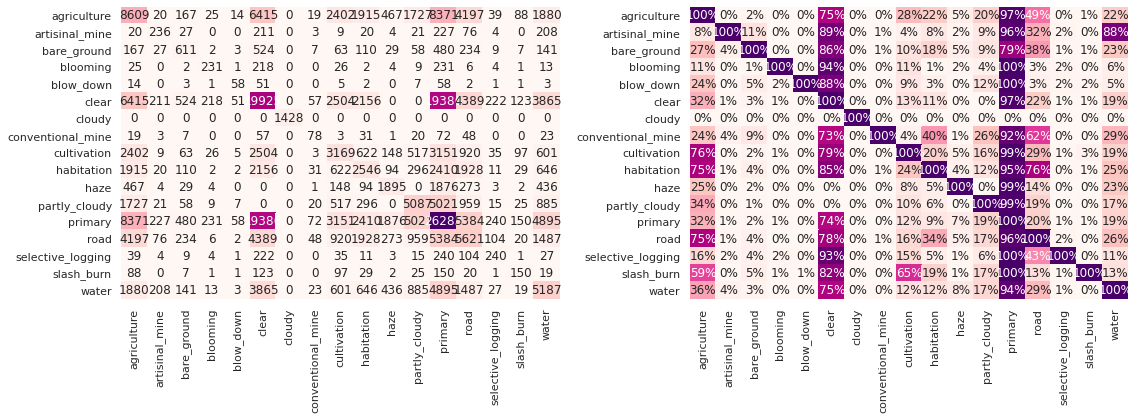

In [17]:
#@title

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

In [18]:
del l, occurrence, co_occurrence, co_occurrence_rate

### Balancing

In [19]:
dominants = [0, 5, 12]
dominated, = np.where(~np.isin(CLASSES_INDICES, dominants))

print('Dominant labels:', dominants)
print('Dominated labels:', dominated)

Dominant labels: [0, 5, 12]
Dominated labels: [ 1  2  3  4  6  7  8  9 10 11 13 14 15 16]


In [20]:
def rebalance(dataset):
  dominant_shards = [
    dataset
    .filter(lambda x: tf.reduce_sum(tf.cast(x['label'] == IDX, tf.uint8)) == 1)
    .repeat()

    for IDX in dominants
  ]

  dominated_shards = [
    dataset
    .filter(lambda x: tf.reduce_any(x['label'] == IDX))
    .repeat()

    for IDX in dominated
  ]

  return tf.data.experimental.sample_from_datasets(
    dominant_shards + dominated_shards,
    np.full(len(CLASSES), 1/len(CLASSES)))

In [21]:
balanced_train_dataset = rebalance(train_dataset)
balanced_valid_dataset = rebalance(valid_dataset)

In [22]:
num_reb_train_steps = int(np.ceil(4 * np.sort(counts)[-len(dominants) -1] / Config.data.batch_size))
num_reb_valid_steps = int(np.ceil(10 * Config.data.valid_size * np.sort(counts)[-len(dominants) -1] / Config.data.batch_size))

print('Rebalanced training steps:', num_reb_train_steps)
print('Rebalanced validation steps:', num_reb_valid_steps)

Rebalanced training steps: 703
Rebalanced validation steps: 527


### Splitting Training and Validation

In [23]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['label']

  image = tf.cast(image, tf.float32)
  image = tf.ensure_shape(image, Config.data.shape)

  image = (tf.numpy_function(auto_augment_fn, [image], tf.uint8)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  return image, labels_to_one_hot(labels)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=True)
            .prefetch(Config.data.prefetch_buffer_size))

### Augmentation Policy

In [24]:
from PIL import Image

def default_policy_fn(image):
  return image

def auto_augment_fn(image):
  image = Image.fromarray(np.uint8(image))
  return np.asarray(Config.data.aug_policy(image))

# def augment_policy_fn(image):
#   seeds = R.make_seeds(6)

#   image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
#   image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
#   image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
#   image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
#   image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
#   image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

#   return image

In [25]:
train = prepare(balanced_train_dataset, Config.data.batch_size, shuffle=Config.data.shuffle, augment=True)
valid = prepare(valid_dataset, Config.data.batch_size)

### Examples

In [26]:
#@title

for stage, batches, samples in zip(('training', 'validation', 'testing'),
                                   (train, valid),
                                   (AmazonFromSpace.num_train_samples,
                                    num_valid_samples,
                                    AmazonFromSpace.num_test_samples)):
  print(stage)
  print(f'  {batches}')
  print(f'  samples: {samples}')
  print(f'  steps  : {samples // Config.data.batch_size}')
  print()

training
  <PrefetchDataset shapes: (<unknown>, (32, 17)), types: (tf.uint8, tf.float32)>
  samples: 40479
  steps  : 1264

validation
  <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 17)), types: (tf.float32, tf.float32)>
  samples: 12143
  steps  : 379



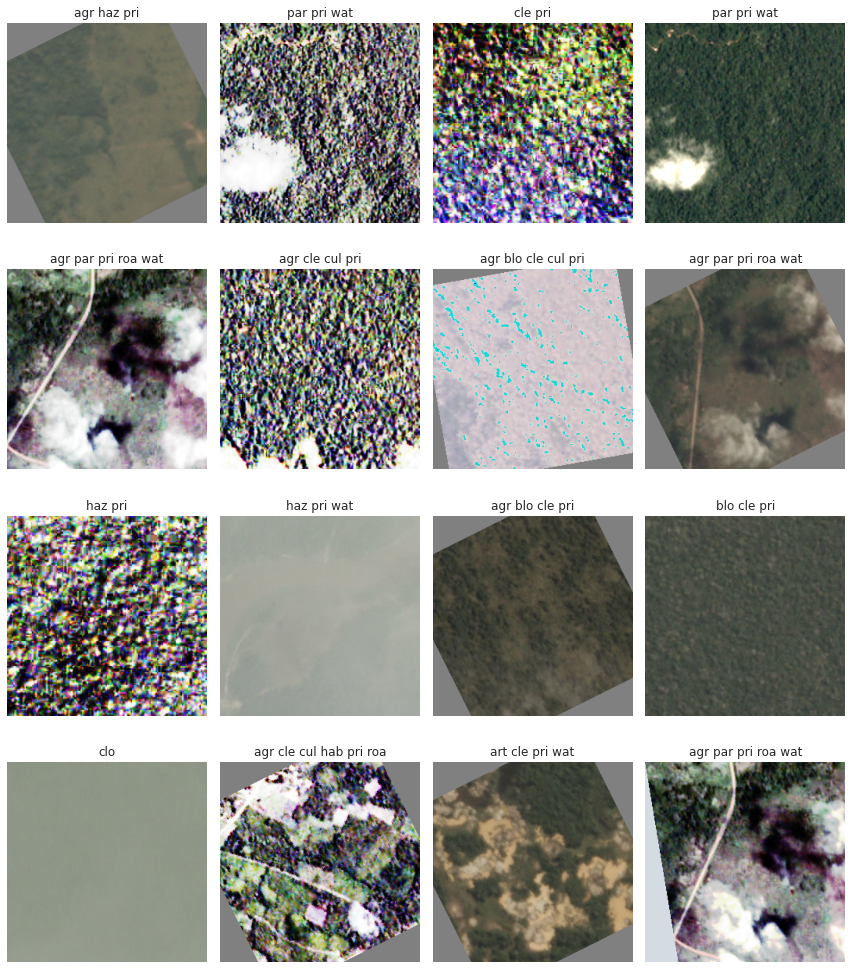

In [27]:
#@title

for images, labels in train.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str))) for l in labels.numpy().astype(bool)]
  visualize(Config.data.deprocess(images[:16]), gt, rows=4, figsize=(12, 14));

## Network

### Backbone

In [28]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)

Loading EfficientNetB3


In [29]:
backbone = tf.keras.Model(
  inputs=backbone.inputs,
  outputs=[backbone.get_layer(l).output for l in Config.model.feature_layers]
)

### Classification Head

In [30]:
from tensorflow.keras.layers import Conv2D, Dropout, Dense


def build_classifier(backbone, opts):
  opts = opt_or_default(opts)

  x = tf.keras.Input(Config.data.shape, name='images')
  
  activations = backbone(x)
  features = []

  for ix, y in enumerate(activations):
    y = tfa.layers.SpatialPyramidPooling2D(bins=[1, 3, 5], name=f'pyramid_features_{ix}')(y)
    y = tf.keras.layers.GlobalMaxPooling1D(name=f'max_pool_{ix}')(y)
    features.append(y)
  
  y = tf.keras.layers.concatenate(features)
  y = Dense(len(CLASSES), name='predictions', **opts('predictions'))(y)

  return tf.keras.Model(
    inputs=x,
    outputs=y,
    name=f'clf_{Config.model.backbone.__name__}_puafs')

In [31]:
nn = build_classifier(backbone, Config.model.build_options)

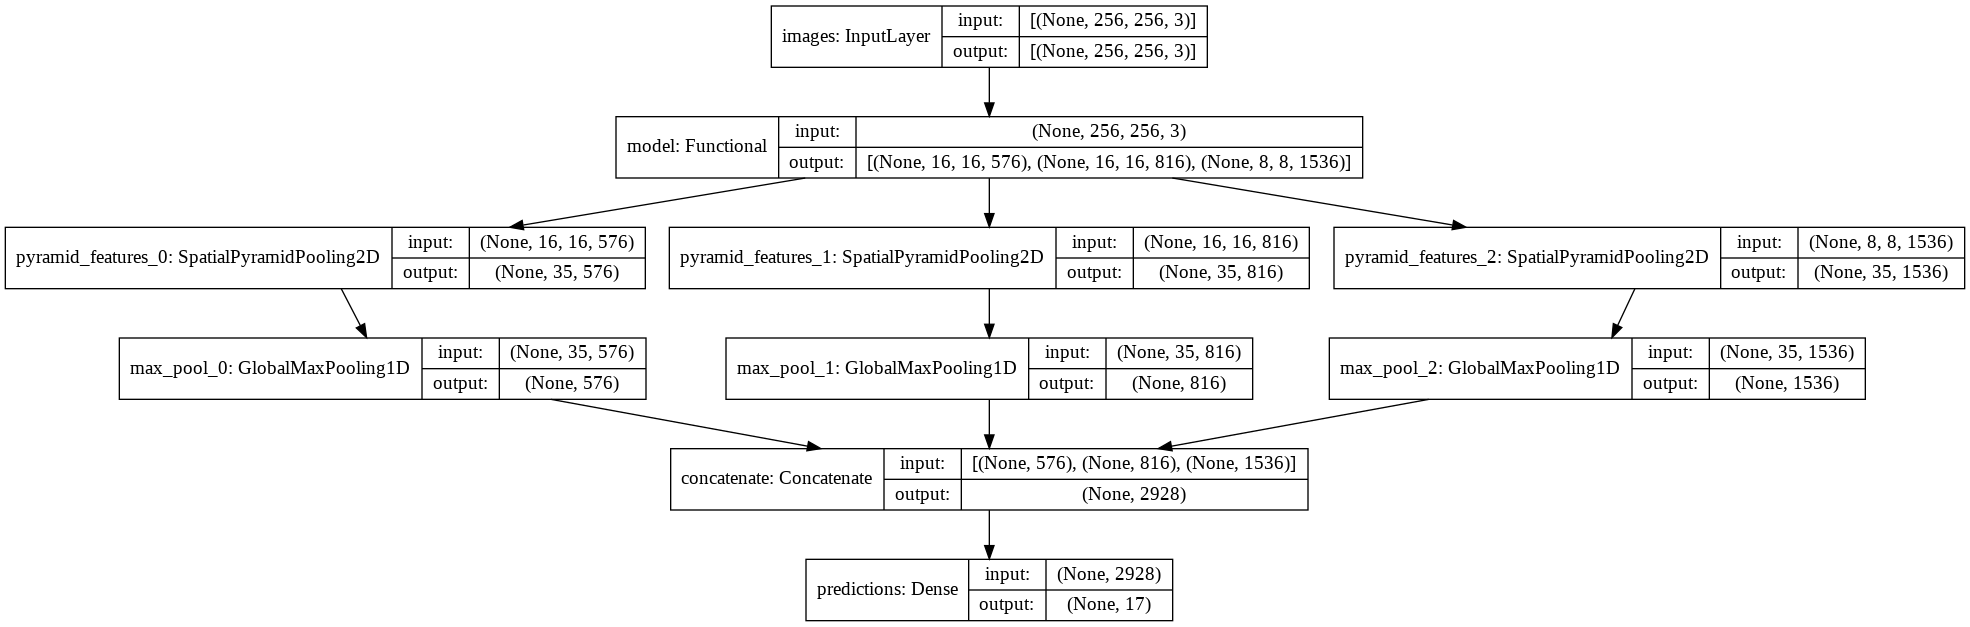

In [32]:
tf.keras.utils.plot_model(nn, show_shapes=True)

## Metrics

In [33]:
# Fix for tensorflow metrics that do not support
# sigmoid_crossentropy_with_logits, for some reason...

class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)

In [34]:
class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

class MultiLabelConfusionMatrix(FromLogitsMixin, tfa.metrics.MultiLabelConfusionMatrix):
  ...

## Training

In [35]:
def train_fn(
    epochs: int = 80,
    initial_epoch: int = 0,
    callbacks: Optional[List[tf.keras.callbacks.Callback]] = None,
    steps_per_epoch: Optional[int] = None,
    validation_steps: Optional[int] = None,

    logs: str = None,
    weights: str = None,

    class_weight: Optional[np.ndarray] = None
):
  try:
    if logs and os.path.exists(logs) and initial_epoch == 0:
      if not Config.experiment.override:
        raise ValueError(f'A training was found in {logs}. '
                         f'Either move it or set experiment.override to True.')

      print(f'Overriding previous training at {logs}.')
      shutil.rmtree(logs)

    if weights: os.makedirs(os.path.dirname(weights), exist_ok=True)

    nn.fit(
      train.repeat(),
      validation_data=valid.repeat(),
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      initial_epoch=initial_epoch,
      callbacks=callbacks,
      class_weight=class_weight);

  except KeyboardInterrupt: print('\ninterrupted')
  else: print('\ndone')

### Top Classifier Training

In [36]:
backbone.trainable = False

In [37]:
nn.compile(
    optimizer=Config.training.optimizer,
    loss=Config.training.loss,
    metrics=[
      Precision(from_logits=True),
      Recall(from_logits=True),
      F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
      MultiLabelConfusionMatrix(num_classes=len(CLASSES), from_logits=True),
      tf.metrics.AUC(multi_label=True, from_logits=True),
    ])

In [ ]:
train_fn(
  epochs=Config.training.epochs,
  steps_per_epoch=num_reb_train_steps,
  validation_steps=num_valid_samples // Config.data.batch_size,
  callbacks=Config.training.callbacks,
  logs=Config.training.logs,
  weights=Config.training.weights
)

In [40]:
train_fn(
  epochs=Config.training.epochs,
  initial_epoch=2,
  steps_per_epoch=num_reb_train_steps,
  validation_steps=num_valid_samples // Config.data.batch_size,
  callbacks=Config.training.callbacks,
  logs=Config.training.logs,
  weights=Config.training.weights
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric MultiLabelConfusionMatrix implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


Epoch 3/80
352/352 [==============================] - 660s 2s/step - loss: 25.4501 - precision: 0.7515 - recall: 0.5121 - f1_score: 0.2269 - Multilabel_confusion_matrix: 5632.0000 - auc: 0.6501 - val_loss: 9.4679 - val_precision: 0.7654 - val_recall: 0.4110 - val_f1_score: 0.1551 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc: 0.6766

Epoch 00003: val_loss improved from 11.52124 to 9.46786, saving model to /content/drive/MyDrive/models/amazon-from-space-mo444/eb6-ce-full.h5
Epoch 4/80
352/352 [==============================] - 626s 2s/step - loss: 25.0020 - precision: 0.7515 - recall: 0.5117 - f1_score: 0.2254 - Multilabel_confusion_matrix: 5632.0000 - auc: 0.6498 - val_loss: 17.5981 - val_precision: 0.5863 - val_recall: 0.7257 - val_f1_score: 0.2257 - val_Multilabel_confusion_matrix: 3024.0000 - val_auc: 0.7389

Epoch 00004: val_loss did not improve from 9.46786
Epoch 5/80
352/352 [==============================] - 613s 2s/step - loss: 25.1770 - precision: 0.7514 - recall: 0.5

### Fine-Tuning

In [36]:
trained_epochs = 16
backbone.trainable = False
nn.load_weights(Config.training.weights)

In [37]:
unfreeze_top_layers(
  backbone,
  Config.fine_tuning.unfreeze_layers,
  Config.fine_tuning.frozen_bn
)

nn.compile(
  optimizer=Config.fine_tuning.optimizer,
  loss=Config.fine_tuning.loss,
  metrics=[
    Precision(from_logits=True, name='precision'),
    Recall(from_logits=True, name='recall'),
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro', name='f1_score'),
    MultiLabelConfusionMatrix(num_classes=len(CLASSES), from_logits=True, name='Multilabel_confusionmatrix'),
    tf.metrics.AUC(multi_label=True, from_logits=True, name='auc'),
  ])

Unfreezing 100% layers. Bottom-most is the 0-nth layer (input_1).


In [ ]:
train_fn(
  epochs=Config.fine_tuning.epochs,
  initial_epoch=trained_epochs,
  steps_per_epoch=num_reb_train_steps,
  validation_steps=num_valid_samples // Config.data.batch_size,
  callbacks=Config.fine_tuning.callbacks,
  logs=Config.fine_tuning.logs,
  weights=Config.fine_tuning.weights,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/80
703/703 [==============================] - ETA: 0s - loss: 0.8782 - precision: 0.9000 - recall: 0.5432 - f1_score: 0.1582 - Multilabel_confusionmatrix: 5624.0000 - auc: 0.8506

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric MultiLabelConfusionMatrix implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


703/703 [==============================] - 2103s 3s/step - loss: 0.8782 - precision: 0.9000 - recall: 0.5432 - f1_score: 0.1582 - Multilabel_confusionmatrix: 5624.0000 - auc: 0.8506 - val_loss: 0.3106 - val_precision: 0.9650 - val_recall: 0.6829 - val_f1_score: 0.2203 - val_Multilabel_confusionmatrix: 3032.0000 - val_auc: 0.9359

Epoch 00017: val_loss improved from inf to 0.31057, saving model to /content/drive/MyDrive/models/amazon-from-space-mo444/eb6-ce-full-ft.h5
Epoch 18/80
703/703 [==============================] - 765s 1s/step - loss: 0.4237 - precision: 0.9311 - recall: 0.6057 - f1_score: 0.1795 - Multilabel_confusionmatrix: 5624.0000 - auc: 0.9123 - val_loss: 0.2518 - val_precision: 0.9641 - val_recall: 0.7265 - val_f1_score: 0.2023 - val_Multilabel_confusionmatrix: 3032.0000 - val_auc: 0.9487

Epoch 00018: val_loss improved from 0.31057 to 0.25176, saving model to /content/drive/MyDrive/models/amazon-from-space-mo444/eb6-ce-full-ft.h5
Epoch 19/80
703/703 [====================

## Evaluation

In [ ]:
#@title


def labels_and_probs(nn, dataset, steps=None):
  labels_ = []
  probs_ = []

  for i, (images, labels) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='' if i % 80 else '\n')

    if steps and i >= steps: break
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))


def evaluate(l, p):
  acc, tpr, fpr, tnr, fnr, auc, mcm = metrics_per_label(l, p)

  return pd.DataFrame({
    'accuracy': acc,
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'roc auc score': auc,
    'support': tf.cast(tf.reduce_sum(l, axis=0), tf.int32),
    'label': CLASSES
  })

In [ ]:
unfreeze_top_layers(
  backbone,
  Config.fine_tuning.unfreeze_layers,
  Config.fine_tuning.frozen_bn
)

nn.load_weights(Config.fine_tuning.weights)

Unfreezing 100% layers. Bottom-most is the 0-nth layer (input_1).


In [ ]:
l, p = labels_and_probs(nn, valid, num_reb_valid_steps)

.
................................................................................
................................................................................
................................................................................
................................................................................
..........................................................

In [ ]:
from sklearn import metrics as skmetrics

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_

  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  skmetrics.accuracy_score(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm

test_report, test_mcm = metrics_per_label(l, p)

In [ ]:
test_report.round(4)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.7463,0.9486,0.0514,0.2537,0.8645,0.7463,0.9476,0.8010,0.7673,3701,agriculture
1,0.7184,0.9983,0.0017,0.2816,0.7872,0.7184,0.9937,0.7513,0.7312,103,artisinal_mine
2,0.1440,0.9957,0.0043,0.8560,0.4138,0.1440,0.8102,0.2136,0.1656,250,bare_ground
3,0.2772,0.9889,0.0111,0.7228,0.1739,0.2772,0.9136,0.2137,0.2478,101,blooming
4,0.1750,0.9991,0.0009,0.8250,0.3889,0.1750,0.8248,0.2414,0.1966,40,blow_down
5,0.9203,0.9595,0.0405,0.0797,0.9815,0.9203,0.9829,0.9499,0.9319,8496,clear
6,0.6394,0.9973,0.0027,0.3606,0.9316,0.6394,0.9937,0.7583,0.6822,660,cloudy
7,0.3182,1.0000,0.0000,0.6818,1.0000,0.3182,0.9909,0.4828,0.3684,22,conventional_mine
8,0.4040,0.9789,0.0211,0.5960,0.6984,0.4040,0.8965,0.5119,0.4412,1307,cultivation
9,0.5386,0.9896,0.0104,0.4614,0.8392,0.5386,0.9480,0.6561,0.5802,1114,habitation


In [ ]:
d = tf.cast(p > 0.5, tf.float32)
co_occurrence = tf.transpose(d) @ d
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

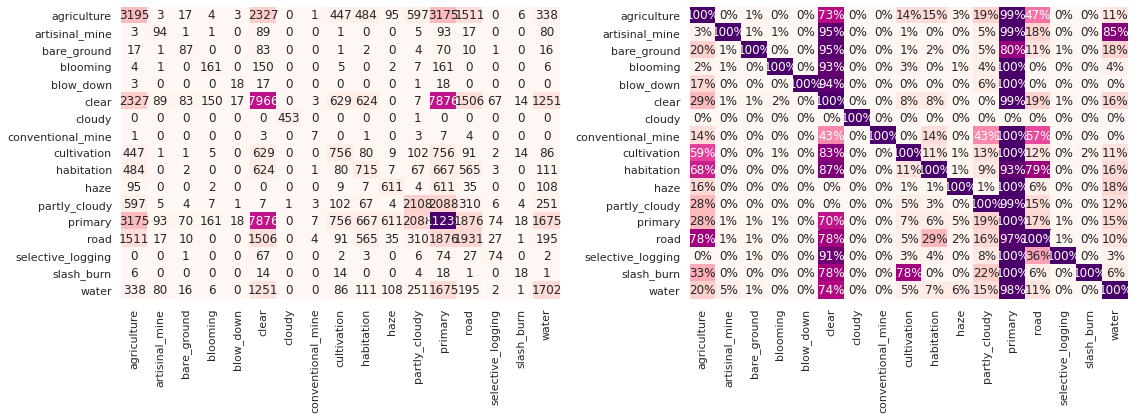

In [ ]:
#@title Predictions Relation Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();

## Generate Answers

In [ ]:
%%bash

if [ ! -f /root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords ]; then
  mkdir -p /root/tensorflow_datasets/amazon-from-space/
  cp /content/drive/MyDrive/datasets/amazon-from-space/test-jpg.tfrecords \
    /root/tensorflow_datasets/amazon-from-space/
fi

In [ ]:
test_dataset = AmazonFromSpace.load('/root/tensorflow_datasets/amazon-from-space/test-jpg.tfrecords')

In [ ]:
test = (
  test_dataset
  .map(lambda item: (item['filename'], load_fn(item)[0]), num_parallel_calls=tf.data.AUTOTUNE)
  .batch(64)
  .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
def filenames_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for ix, (files, images) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(files)
    probs_.append(y)

    print('.', end='' if ix % 200 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

In [ ]:
files, preds = filenames_and_probs(nn, test)

In [ ]:
detection_threshold = 0.5

answer = pd.DataFrame({
  'image_name': files.numpy().astype(str),
  'tags': [' '.join(AmazonFromSpace.int2str(p)) for p in (preds > detection_threshold).numpy()]
})
answer['image_name'] = answer.image_name.str.split('.').str[0]
answer.head()

In [ ]:
answer.to_csv(os.path.join(Config.fine_tuning.logs, 'test_answer.csv'), index=False)